In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# plt.style.use('ggplot')

In [ ]:
def create_dataset_from_scots(controller_filename, deterministic = False):
    f = open(controller_filename, "r")
    lines = []
    for line in f:
        if '#MATRIX:DATA\n' in line:                
            for line in f: # now you are at the lines you want
                # skip the #BEGIN 
                # read the state-actions
                lines = f.readlines()
    del lines[-1] # delete #END
    # take the state as the train dataset
    list_train_dataset = []
    for x in lines:
        list_train_dataset.append(x.split(' ')[0])
    # convert to the numpy array with float32 data type
    train_dataset = np.asarray(list_train_dataset)
    train_dataset = train_dataset.astype(np.float32)
    # take action/label pair of the state 
    # take the action(s) [column 1:-1] / the rest of the integer except the state
    list_train_label = []
    for x in lines:
        if deterministic == False:
            list_train_label.append(x.strip().split()[1:])
        else:
            list_train_label.append(x.strip().split()[1])
    # convert to numpy array, note that the result is still not in one hot encoding format
    train_label = np.asarray(list_train_label)
    # define number of samples
    num_samples = train_label.shape[0]
    if deterministic == False:
        # select to use ND or D case here
        # create now array to be filled by the encoded label
        train_label_hot = np.zeros([num_samples,2], dtype=np.float32)
        # encode label to one hot encoding format
        for i in range(num_samples):
            if train_label[i] == ['0']:
                train_label_hot[i] = [1, 0]
            elif train_label[i] == ['1']:
                train_label_hot[i] = [0, 1]
            elif train_label[i] == ['0','1']:
                train_label_hot[i] = [1, 1]
    else:
        train_label_hot = train_label[:, None].astype(np.uint8)

    

In [100]:
det = True

In [127]:
# parse the controller file
f = open('../COTONN/dcdc_small/controller.scs', "r")

lines = []

for line in f:
    if '#MATRIX:DATA\n' in line:                
        for line in f: # now you are at the lines you want
            # skip the #BEGIN 
            # read the state-actions
            lines = f.readlines()
            
del lines[-1]

# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[0])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[1:])
    else:
        ltrain_label.append(x.strip().split()[1])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label)

# define number of samples
num_samples = train_dataset.shape[0]

if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_hot = np.zeros([num_samples,2], dtype=np.float32)

    # encode label to one hot encoding format
    for i in range(num_samples):
        if train_label[i] == ['0']:
            train_label_hot[i] = [1, 0]
        elif train_label[i] == ['1']:
            train_label_hot[i] = [0, 1]
        elif train_label[i] == ['0','1']:
            train_label_hot[i] = [1, 1]
else:
    train_label_hot = train_label[:, None].astype(np.uint8)
    


In [44]:
len(max(ltrain_label,key=len))

2

In [49]:
label_array = np.array([np.array(actions) for actions in ltrain_label])

In [54]:
label_array.astype(np.uint8)

ValueError: setting an array element with a sequence.

In [128]:
train_label_hot.shape

(8677, 1)

In [129]:
upper_limit = train_dataset.shape[0]
upper_limit

8677

In [130]:
train_label_hot

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [131]:
train_dataset_dim = train_dataset[:, None]
# slice the samples
train_sliced = train_dataset_dim[:upper_limit]
# change it to init
train_sliced_int = train_sliced.astype(np.uint32)
# split to 4 bytes
tsi8_unordered = train_sliced_int.view(np.uint8)
# little endian format
tsi8 = np.flip(tsi8_unordered,1)
# unpack
toy_vehicle_input_unreduced = np.unpackbits(tsi8).reshape(-1,32)

# get index of MSB
msb = len(bin(int(np.max(train_dataset_dim))))-2
# get total bit
total_bit = toy_vehicle_input_unreduced.shape[1]
# reduce to the minimal binary representation
toy_vehicle_input = toy_vehicle_input_unreduced[:, np.arange(total_bit-msb,total_bit)]

num_label = train_label_hot.shape[1]

input_size = toy_vehicle_input.shape[1]

train_dataset_reform = toy_vehicle_input

In [132]:
def accuracy_softmax(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
  return (100.0 * np.mean(predictions == labels))

In [133]:
tf.reset_default_graph()
batch_size = 128 # num_samples # (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)

In [134]:
print(batch_size)
print(num_batches)

128
68.0


In [135]:
hidden_size = 8
hidden_size2 = 8

# with tf.device('/device:GPU:0'):
# Input data. For the training data, we use a placeholder that will be fed
# at run time with a training minibatch.
# tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
# tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))
tf_train_dataset = tf.placeholder(tf.float32, shape=(None, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_label))
dropout_prob = tf.placeholder(tf.float32)

# Variables.
weights1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))

# weights2 = tf.Variable(tf.truncated_normal([hidden_size, num_label]))
# biases2 = tf.Variable(tf.zeros([num_label]))

weights2 = tf.Variable(tf.truncated_normal([hidden_size, hidden_size2]))
biases2 = tf.Variable(tf.zeros([hidden_size2]))

weights3 = tf.Variable(tf.truncated_normal([hidden_size2, num_label]))
biases3 = tf.Variable(tf.zeros([num_label]))

"""
# weights4 = tf.Variable(tf.truncated_normal([hidden_size3, num_label]))
# biases4 = tf.Variable(tf.zeros([num_label]))
weights4 = tf.Variable(tf.truncated_normal([hidden_size3, hidden_size4]))
biases4 = tf.Variable(tf.zeros([hidden_size4]))

weights5 = tf.Variable(tf.truncated_normal([hidden_size4, num_label]))
biases5 = tf.Variable(tf.zeros([num_label]))
"""

# Training computation.
logits1 = tf.matmul(tf_train_dataset, weights1) + biases1  
relu_act_func_d = tf.nn.sigmoid(logits1)
relu_act_func = tf.nn.dropout(relu_act_func_d, dropout_prob)

logits2 = tf.matmul(relu_act_func, weights2) + biases2
relu_act_func2_d = tf.nn.sigmoid(logits2)
relu_act_func2 = tf.nn.dropout(relu_act_func2_d, dropout_prob)

logits3 = tf.matmul(relu_act_func2, weights3) + biases3

"""
relu_act_func3 = tf.nn.relu(logits3)
logits4 = tf.matmul(relu_act_func3, weights4) + biases4

relu_act_func4 = tf.nn.relu(logits4)
logits5 = tf.matmul(relu_act_func4, weights5) + biases5
"""

logits = logits3
train_prediction = tf.round(tf.sigmoid(logits))

# loss calculation
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits5))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

loss_summary = tf.summary.scalar('loss', loss)
# optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.0015).minimize(loss)


In [136]:
loss_history = []

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0
loss_disp_true = False

with tf.Session() as session:
# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
#with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while acc < 95:
        epoch_idx += 1
        acc_cum = 0
        for step in range(int(num_batches)):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
        
            offset = (step * batch_size)
            
            if num_samples > offset + batch_size:
                batch_limit = offset + batch_size
            else:
                batch_limit = num_samples
                loss_disp_true = True
                       
            # offset = np.random.randint(num_samples - batch_size , size = 1)[0]
            # Generate a minibatch.
            batch_data = train_dataset_reform[offset:(batch_limit), :]
            batch_labels = train_label_hot[offset:(batch_limit), :]

            # print(offset)
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
            _, l, predictions, added_summary, logits_check = session.run(
                [optimizer, loss, train_prediction, loss_summary, logits], feed_dict=feed_dict)

            # writer.add_summary(added_summary)
            acc_temp =  accuracy_multilabel(predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            if loss_disp_true:
                loss_disp_true = False
                loss_history.append(l)
                print("Epoch {0:6d} batch_limit: {1:6d} Loss: {2:8.4f} Training Acc: {3:8.2f} {4:8.2f} {5:8.2f}%".format(epoch_idx, batch_limit, l, acc_temp, acc_cum, acc))

"""
    # Do for the test batch
    acc = 0
    for step in range(num_batches):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_reform[offset:(offset + batch_size), :]
        batch_labels = train_label_hot[offset:(offset + batch_size), :]

        # print(offset)
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
        test_predictions = session.run(train_prediction, feed_dict=feed_dict)
        print(offset, offset + batch_size)
        # print(batch_labels)
        # print(test_predictions)
        batch_acc = accuracy_multilabel(test_predictions, batch_labels)
        print("Minibatch accuracy: %.1f%%" % batch_acc)
        acc = acc + batch_acc

    print(acc)
"""

Initialized
Epoch      1 batch_limit:   8677 Loss:   0.2717 Training Acc:    96.04  5592.13    82.24%
Epoch      2 batch_limit:   8677 Loss:   0.2585 Training Acc:    96.04  5592.91    82.25%
Epoch      3 batch_limit:   8677 Loss:   0.2555 Training Acc:    96.04  5592.91    82.25%
Epoch      4 batch_limit:   8677 Loss:   0.2538 Training Acc:    96.04  5592.91    82.25%
Epoch      5 batch_limit:   8677 Loss:   0.2525 Training Acc:    96.04  5592.91    82.25%
Epoch      6 batch_limit:   8677 Loss:   0.2514 Training Acc:    96.04  5592.91    82.25%
Epoch      7 batch_limit:   8677 Loss:   0.2504 Training Acc:    96.04  5592.91    82.25%
Epoch      8 batch_limit:   8677 Loss:   0.2496 Training Acc:    96.04  5592.91    82.25%
Epoch      9 batch_limit:   8677 Loss:   0.2488 Training Acc:    96.04  5592.91    82.25%
Epoch     10 batch_limit:   8677 Loss:   0.2481 Training Acc:    96.04  5592.91    82.25%
Epoch     11 batch_limit:   8677 Loss:   0.2474 Training Acc:    96.04  5592.91    82.25

Epoch     92 batch_limit:   8677 Loss:   0.2246 Training Acc:    96.04  5592.91    82.25%
Epoch     93 batch_limit:   8677 Loss:   0.2244 Training Acc:    96.04  5592.91    82.25%
Epoch     94 batch_limit:   8677 Loss:   0.2243 Training Acc:    96.04  5592.91    82.25%
Epoch     95 batch_limit:   8677 Loss:   0.2241 Training Acc:    96.04  5592.91    82.25%
Epoch     96 batch_limit:   8677 Loss:   0.2240 Training Acc:    96.04  5592.91    82.25%
Epoch     97 batch_limit:   8677 Loss:   0.2238 Training Acc:    96.04  5592.91    82.25%
Epoch     98 batch_limit:   8677 Loss:   0.2237 Training Acc:    96.04  5592.91    82.25%
Epoch     99 batch_limit:   8677 Loss:   0.2235 Training Acc:    96.04  5592.91    82.25%
Epoch    100 batch_limit:   8677 Loss:   0.2234 Training Acc:    96.04  5592.91    82.25%
Epoch    101 batch_limit:   8677 Loss:   0.2232 Training Acc:    96.04  5592.91    82.25%
Epoch    102 batch_limit:   8677 Loss:   0.2231 Training Acc:    96.04  5592.91    82.25%
Epoch    1

Epoch    184 batch_limit:   8677 Loss:   0.1837 Training Acc:    96.04  5666.35    83.33%
Epoch    185 batch_limit:   8677 Loss:   0.1828 Training Acc:    96.04  5668.70    83.36%
Epoch    186 batch_limit:   8677 Loss:   0.1819 Training Acc:    96.04  5667.13    83.34%
Epoch    187 batch_limit:   8677 Loss:   0.1811 Training Acc:    96.04  5669.48    83.37%
Epoch    188 batch_limit:   8677 Loss:   0.1802 Training Acc:    96.04  5669.48    83.37%
Epoch    189 batch_limit:   8677 Loss:   0.1793 Training Acc:    96.04  5669.48    83.37%
Epoch    190 batch_limit:   8677 Loss:   0.1785 Training Acc:    96.04  5667.91    83.35%
Epoch    191 batch_limit:   8677 Loss:   0.1776 Training Acc:    96.04  5667.91    83.35%
Epoch    192 batch_limit:   8677 Loss:   0.1768 Training Acc:    96.04  5668.70    83.36%
Epoch    193 batch_limit:   8677 Loss:   0.1760 Training Acc:    96.04  5669.48    83.37%
Epoch    194 batch_limit:   8677 Loss:   0.1751 Training Acc:    96.04  5673.38    83.43%
Epoch    1

Epoch    277 batch_limit:   8677 Loss:   0.1449 Training Acc:    96.04  6248.38    91.89%
Epoch    278 batch_limit:   8677 Loss:   0.1450 Training Acc:    96.04  6253.85    91.97%
Epoch    279 batch_limit:   8677 Loss:   0.1451 Training Acc:    96.04  6257.76    92.03%
Epoch    280 batch_limit:   8677 Loss:   0.1452 Training Acc:    96.04  6259.32    92.05%
Epoch    281 batch_limit:   8677 Loss:   0.1453 Training Acc:    96.04  6259.32    92.05%
Epoch    282 batch_limit:   8677 Loss:   0.1455 Training Acc:    96.04  6259.32    92.05%
Epoch    283 batch_limit:   8677 Loss:   0.1456 Training Acc:    96.04  6265.57    92.14%
Epoch    284 batch_limit:   8677 Loss:   0.1457 Training Acc:    96.04  6268.70    92.19%
Epoch    285 batch_limit:   8677 Loss:   0.1459 Training Acc:    96.04  6274.16    92.27%
Epoch    286 batch_limit:   8677 Loss:   0.1461 Training Acc:    96.04  6275.73    92.29%
Epoch    287 batch_limit:   8677 Loss:   0.1462 Training Acc:    96.04  6281.20    92.37%
Epoch    2

'\n    # Do for the test batch\n    acc = 0\n    for step in range(num_batches):\n        # Pick an offset within the training data, which has been randomized.\n        # Note: we could use better randomization across epochs.\n        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)\n        # Generate a minibatch.\n        batch_data = train_dataset_reform[offset:(offset + batch_size), :]\n        batch_labels = train_label_hot[offset:(offset + batch_size), :]\n\n        # print(offset)\n        # Prepare a dictionary telling the session where to feed the minibatch.\n        # The key of the dictionary is the placeholder node of the graph to be fed,\n        # and the value is the numpy array to feed to it.\n        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}\n        test_predictions = session.run(train_prediction, feed_dict=feed_dict)\n        print(offset, offset + batch_size)\n        # print(batch_labels)\

In [ ]:
tf_train_dataset

In [137]:
acc/num_batches

1.3975760614015555

In [ ]:
np.sum(train_label_hot)

In [113]:
hidden = str(hidden_size)+str(hidden_size2)

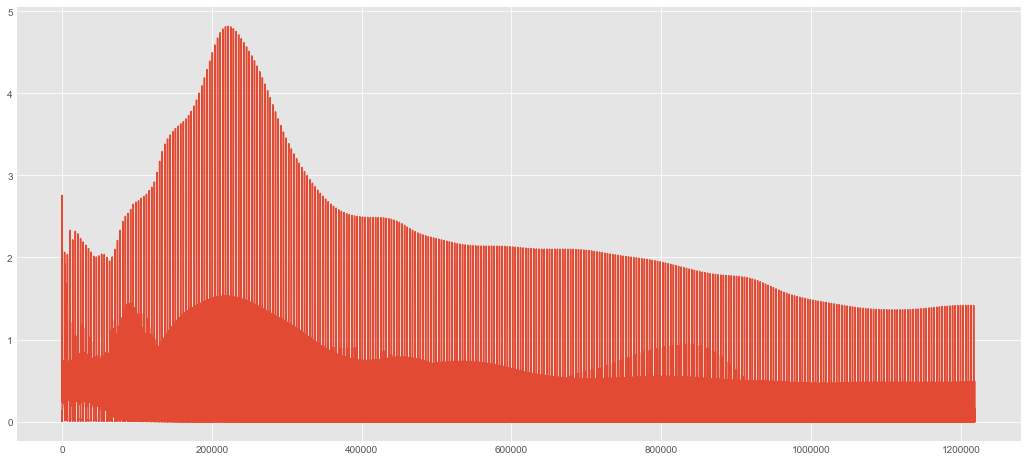

<Figure size 1296x576 with 0 Axes>

In [114]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(loss_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'.png', dpi = 200)

In [65]:
predictions

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [66]:
batch_labels

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
np.mean(predictions == batch_labels)